<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/FER_with_CNN_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"

fatal: destination path 'EC523-Deep-Learning-Project' already exists and is not an empty directory.


In [2]:
!pip install unrar

In [3]:
# !unrar x "EC523-Deep-Learning-Project/datasets/ckplus.rar"
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar


Would you like to replace the existing file fer2013.csv
301108654 bytes, modified on 2020-10-14 22:59
with a new one
301108654 bytes, modified on 2020-10-14 22:59

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


##Imports

In [4]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [5]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label


def reformat_data(X, Y):
    data = []

    for x, y in zip(torch.from_numpy(X), torch.from_numpy(Y)):
        x, y = x.type(torch.DoubleTensor), y.type(torch.long)
        data.append((x.unsqueeze(0), y))

    return data



xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

train = reformat_data(xtrain, ytrain)
val = reformat_data(xval, yval)
test = reformat_data(xtest, ytest)

trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

del train, test, val, xtrain, ytrain, xval, yval, xtest, ytest, fer2013

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([100, 1, 48, 48]) torch.Size([100])


##Model

In [7]:
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.lin1 = nn.Linear(256*6*6, 4096) # Will have to change input size
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)
        
        #self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        # print("shape before linear layers!!: ", x.shape)

        x = x.view(-1, 256*6*6) # will have to change!
        # print("reshaped", x.shape)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

sub1 = Subnet1()

##Training

In [20]:
net = Subnet1()
net = net.to(device)
net.double()

Subnet1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=9216, out_features=4096, bias=True)
  (lin2): Linear(in_features=4096, out_features=4096, bias=True)
  (lin3): Linear(in_features=4096, out_features=7, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
def train_model(net, trainloader, valloader):

    train_loss = []
    val_loss = []
    num = 10
    for epoch in range(6):
        print("Training")
        net = net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % num == num - 1 :    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                train_loss.append(running_loss / num)
                running_loss = 0.0
        
        print("Validating")
        net = net.eval()
        running_loss = 0.0
        for i, data in enumerate(valloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            running_loss += loss.item()
            if i % num == num - 1:    
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / num))
                val_loss.append(running_loss / num)
                running_loss = 0.0

    return train_loss, val_loss

In [28]:
def test_model(net, testloader):
    
    net = net.eval()

    correct_count, n_sampels = 0.0, 0.0
    for data in testloader:
        # seperate data to X, y and more info to GPU
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    
    return acc

In [ ]:
train_loss, val_loss = train_model(net, trainloader, valloader)

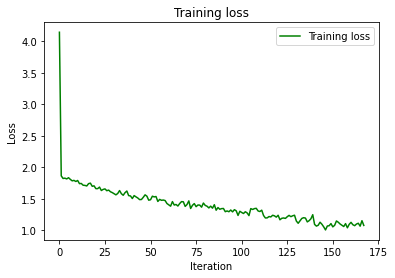

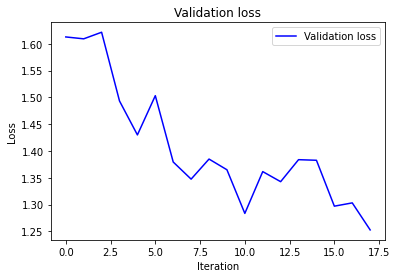

In [27]:
plt.figure()
plt.plot(train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
acc = test_model(net, testloader)
print('Test Accuracy: %d %%' % (acc))

Test Accuracy: 51 %


In [30]:
torch.save(net.state_dict(), "subnet1")